In [1]:
# !pip install -U tensorflow-addons
# !pip install tensorflow_hub
# !pip install opencv-contrib-python --upgrade
# !pip install mutagen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.3 MB/s eta 0:00:00


In [2]:
import os
from easydict import EasyDict
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from glob import glob
import tensorflow_addons as tfa
import numpy as np
from tensorflow.keras import layers
import scipy
import librosa
import imageio
from mutagen.mp3 import MP3
from scipy import signal
import pandas as pd
import time

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
os.chdir(r'/content/drive/MyDrive/DL-CV-ML Projects/AIART/src')

In [4]:
from Parameters import params, directory_params, base_resolutions, functions_mapping, func_params, audio_config, signals_config, num_frames
from StyleGAN2 import StyleGAN2
from Setup import Config, MusicProcessing
from Audioreactive import AudioReactive
from Train import _parse_features, get_dataset, DisplayCallBack
from Music_Processing import normalize
from Network_Bending import Zoom, GaussianBlur, Translation, Rotation, Shear, Blend, Hue, DisplacementMap

/content/drive/MyDrive/DL-CV-ML Projects/AIART/src/Setup.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
image = tf.io.read_file("/content/drive/MyDrive/DL-CV-ML Projects/AIART/wladyslaw-strzeminski_10.jpg")
image = tf.image.decode_image(image, channels=3)
image.set_shape([None, None, 3])
image = tf.image.resize(images=image, size=(512, 512))
image = tf.cast(image[None, ...], tf.float32) / 255

# StyleGAN2 Train

In [6]:
tf.keras.backend.clear_session()
stylegan2 = StyleGAN2(log2_resolution=params.log2res, batch_size=None, latent_dim=512, min_num_features=16, max_num_features=params.max_features, name='StyleGAN2')
stylegan2.compile(steps_per_epoch=params.steps, run_eagerly=False)
stylegan2.build((2, 4, 4, params.max_features))
stylegan2.summary()

Model: "StyleGAN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator (Discriminato  multiple                 0 (unused)
 r)                                                              
                                                                 
 generator (Generator)       multiple                  17285736  
                                                                 
 mapping (Mapping)           multiple                  2101248   
                                                                 
 adaptive_augmenter (Adaptiv  multiple                 0 (unused)
 eAugmenter)                                                     
                                                                 
Total params: 39,230,191
Trainable params: 39,230,179
Non-trainable params: 12
_________________________________________________________________


In [7]:
checkpoint = '/content/drive/MyDrive/DL-CV-ML Projects/AIART/training_checkpoint/7_6_23/ckpt'
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint, save_weights_only=True, save_freq=1000, verbose=0)
train_dl = get_dataset('/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/', resolution=2**params.log2res, bs=2, block_length=50)

['/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/Abstract_gallery', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/images', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/abstract_art_512', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/WikiArt', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/BCERROR', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/train_1', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/train', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/dataset2', '/content/drive/MyDrive/DL-CV-ML Projects/All_Data/AIART/dataset1']


In [8]:
params.steps = 108001

In [9]:
stylegan2.load_weights(checkpoint)

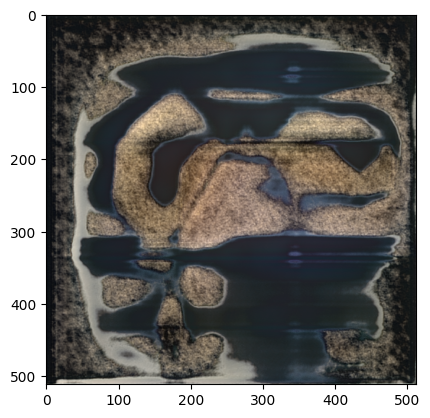

In [10]:
plt.imshow(normalize(stylegan2.generate_images(1), 0, 1)[0])

In [ ]:
stylegan2.fit(train_dl, epochs=30, callbacks=[ckpt_cb, DisplayCallBack()]) # , steps_per_epoch=params.steps,

# Audioreactive.py


In [12]:
directory_params.ckpt_folder_name = '7_6_23'

In [13]:
MakeAudioReactive = AudioReactive(max_features=params.max_features,
                                  log2_resolution=params.log2res,
                                  train_ckpt_base_dir=directory_params.training_checkpoint_directory,
                                  ckpt_folder_name=directory_params.ckpt_folder_name,
                                  ckpt_name=directory_params.ckpt_name,
                                  params=params,
                                  dict_config=dict(**signals_config, **audio_config))

Getting chromagrams...
Getting onsets...
Getting transformations dict...
Getting impulse signals...
loading weights from /content/drive/MyDrive/DL-CV-ML Projects/AIART/training_checkpoint/7_6_23/ckpt


In [14]:
audio_file='/content/drive/MyDrive/DL-CV-ML Projects/AIART/audio/Short_Final/test.mp3'
MakeAudioReactive.generate_video(img_loc=os.path.join(directory_params.output_dir, 'imgs'), out_loc=directory_params.output_dir, audio_file=audio_file, super_res=False)

Getting Preperations...
Generating Images...


  0%|          | 0/2199 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

Adding Audio to Video...
